In [1]:
from myosuite.simhive.myo_sim.test_sims import TestSims as loader
from scipy.signal import butter, filtfilt
from IPython.display import HTML
import matplotlib.pyplot as plt
from base64 import b64encode
import scipy.sparse as spa
from copy import deepcopy
from tqdm import tqdm
import pandas as pd
import numpy as np
import imageio
import mujoco
import osqp
import os

MyoSuite:> Registering Myo Envs


In [2]:
def show_video(video_path, video_width = 400):
    """
    Display a video within the notebook.
    """
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video autoplay width={video_width} controls><source src="{video_url}"></video>""")

def solve_qp(P, q, lb, ub, x0):
    """
    Solve a quadratic program.
    """
    P = spa.csc_matrix(P)
    A = spa.csc_matrix(spa.eye(q.shape[0]))
    m = osqp.OSQP()
    m.setup(P=P, q=q, A=A, l=lb, u=ub, verbose=False)
    m.warm_start(x=x0)
    res = m.solve()
    return res.x

def lowpass_filter(signal, cutoff, fs, order=5):
    """
    Low-pass filter a signal.
    """
    norm_cutoff = cutoff / (0.5 * fs)
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

def plot_qxxx(qxxx, joint_names, label1, label2):
    """
    Plot generalized variables to be compared.
    qxxx[:,0,:] = time axis
    qxxx[:,1:,0] = reference sequence
    qxxx[:,1:,n] = n-th sequence
    """
    fig, axs = plt.subplots(6, 8, figsize=(16, 12))  # Adjust the grid size for 44 joints
    axs = axs.flatten()
    line_objects = []
    for j in range(1, len(joint_names) + 1):
        ax = axs[j - 1]
        for i in range(qxxx.shape[2]):
            line, = ax.plot(qxxx[:, 0, 0], qxxx[:, j, i])
            if j == 1:  # add only one set of lines to the legend
                line_objects.append(line)
        ax.set_ylim([qxxx[:, 1:, :].min(), qxxx[:, 1:, :].max()])
        ax.set_title(joint_names[j - 1])
    legend_ax = axs[len(joint_names)]  # create legend in the last subplot area
    legend_ax.axis('off')
    labels = [label1, label2]
    legend_ax.legend(line_objects, labels, loc='center')
    plt.tight_layout()
    plt.show()

In [3]:
traj = pd.read_csv('traj.csv').values


In [4]:
def get_qfrc(model, data, target_qpos):
    """
    Compute the generalized force needed to reach the target position in the next mujoco step.
    """
    data_copy = deepcopy(data)
    data_copy.qpos = target_qpos
    data_copy.qvel = (target_qpos - data.qpos) / model.opt.timestep
    mujoco.mj_forward(model, data_copy)
    data_copy.qacc = 0
    mujoco.mj_inverse(model, data_copy)
    return data_copy.qfrc_inverse

100%|██████████| 21/21 [00:00<00:00, 828.84it/s]


Error max (rad): 203067.36725945855


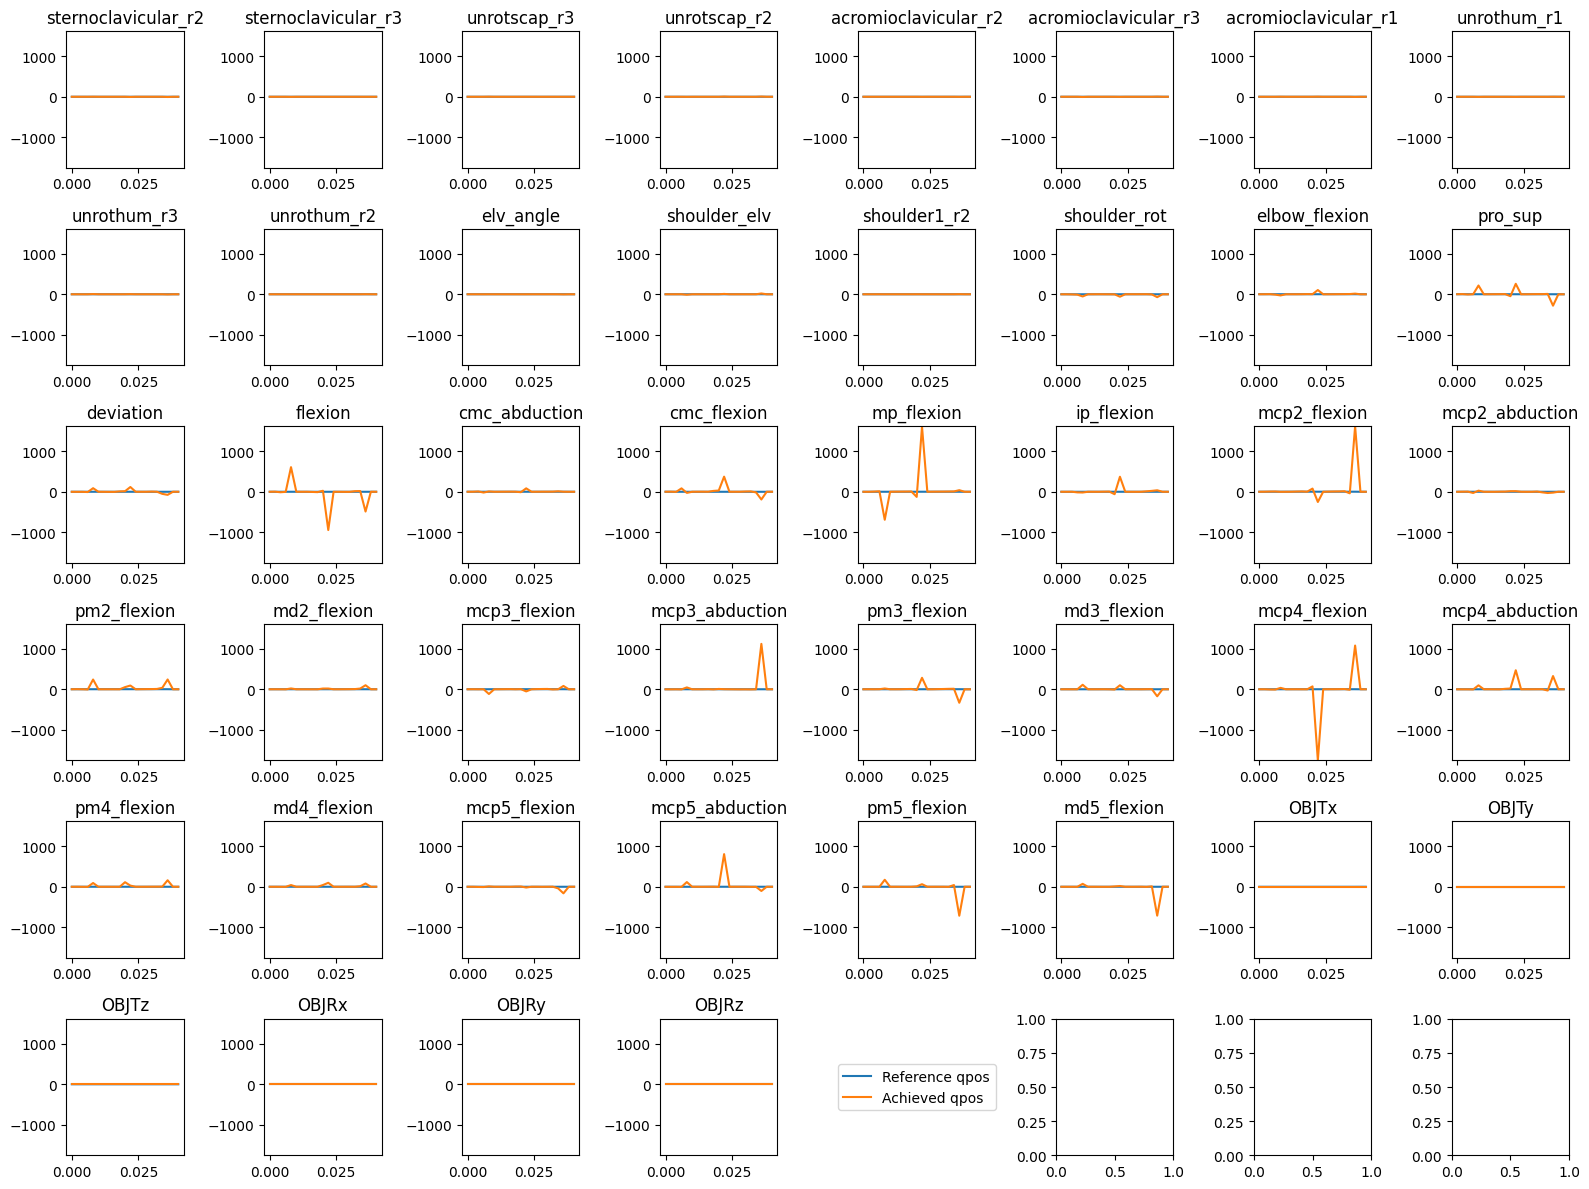

In [5]:
model0 = loader.get_sim(None, 'arm/myoarm_relocate.xml') 
data0 = mujoco.MjData(model0)
all_qpos = np.zeros_like(traj)
all_qfrc = np.zeros_like(traj)
for idx in (pbar := tqdm(range(traj.shape[0]))):
    target_qpos = traj[idx, 1:]
    qfrc = get_qfrc(model0, data0, target_qpos)
    data0.qfrc_applied = qfrc
    mujoco.mj_step(model0, data0)
    all_qpos[idx,:] = np.hstack((data0.time, data0.qpos))
    all_qfrc[idx,:] = np.hstack((data0.time, qfrc))
qpos_eval = np.zeros((traj.shape[0], traj.shape[1], 2))
qpos_eval[:,:,0] = traj
qpos_eval[:,:,1] = all_qpos
error = ((qpos_eval[:,1:,1] - qpos_eval[:,1:,0])**2).mean(axis=0)
print(f'Error max (rad): {error.max()}')
joint_names = [model0.joint(i).name for i in range(model0.nq)]
plot_qxxx(qpos_eval, joint_names, 'Reference qpos', 'Achieved qpos')

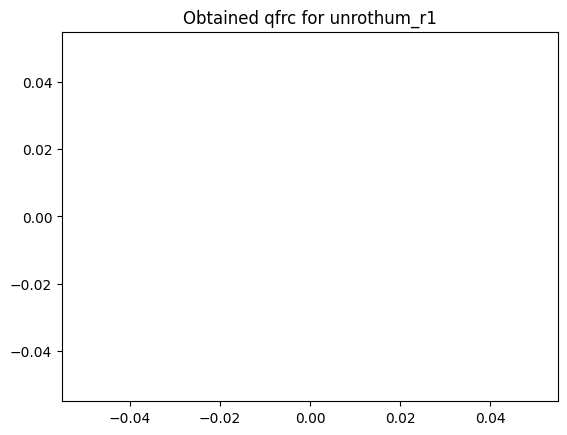

In [6]:
x1 = 2850; x2 = 3500; qidx = 7
plt.plot(all_qfrc[x1:x2,0], all_qfrc[x1:x2,1+qidx])
plt.title(f'Obtained qfrc for {joint_names[qidx]}')
plt.show()

In [7]:
filt_qfrc = np.zeros_like(all_qfrc)
filt_qfrc[:,0] = all_qfrc[:,0]
fs = 1/model0.opt.timestep
cutoff = 5 # Hz
filt_qfrc[:,1:] = np.apply_along_axis(lowpass_filter, 0, all_qfrc[:,1:], cutoff, fs)

100%|██████████| 21/21 [00:00<00:00, 2310.43it/s]


Error max (rad): 65310835.18101035


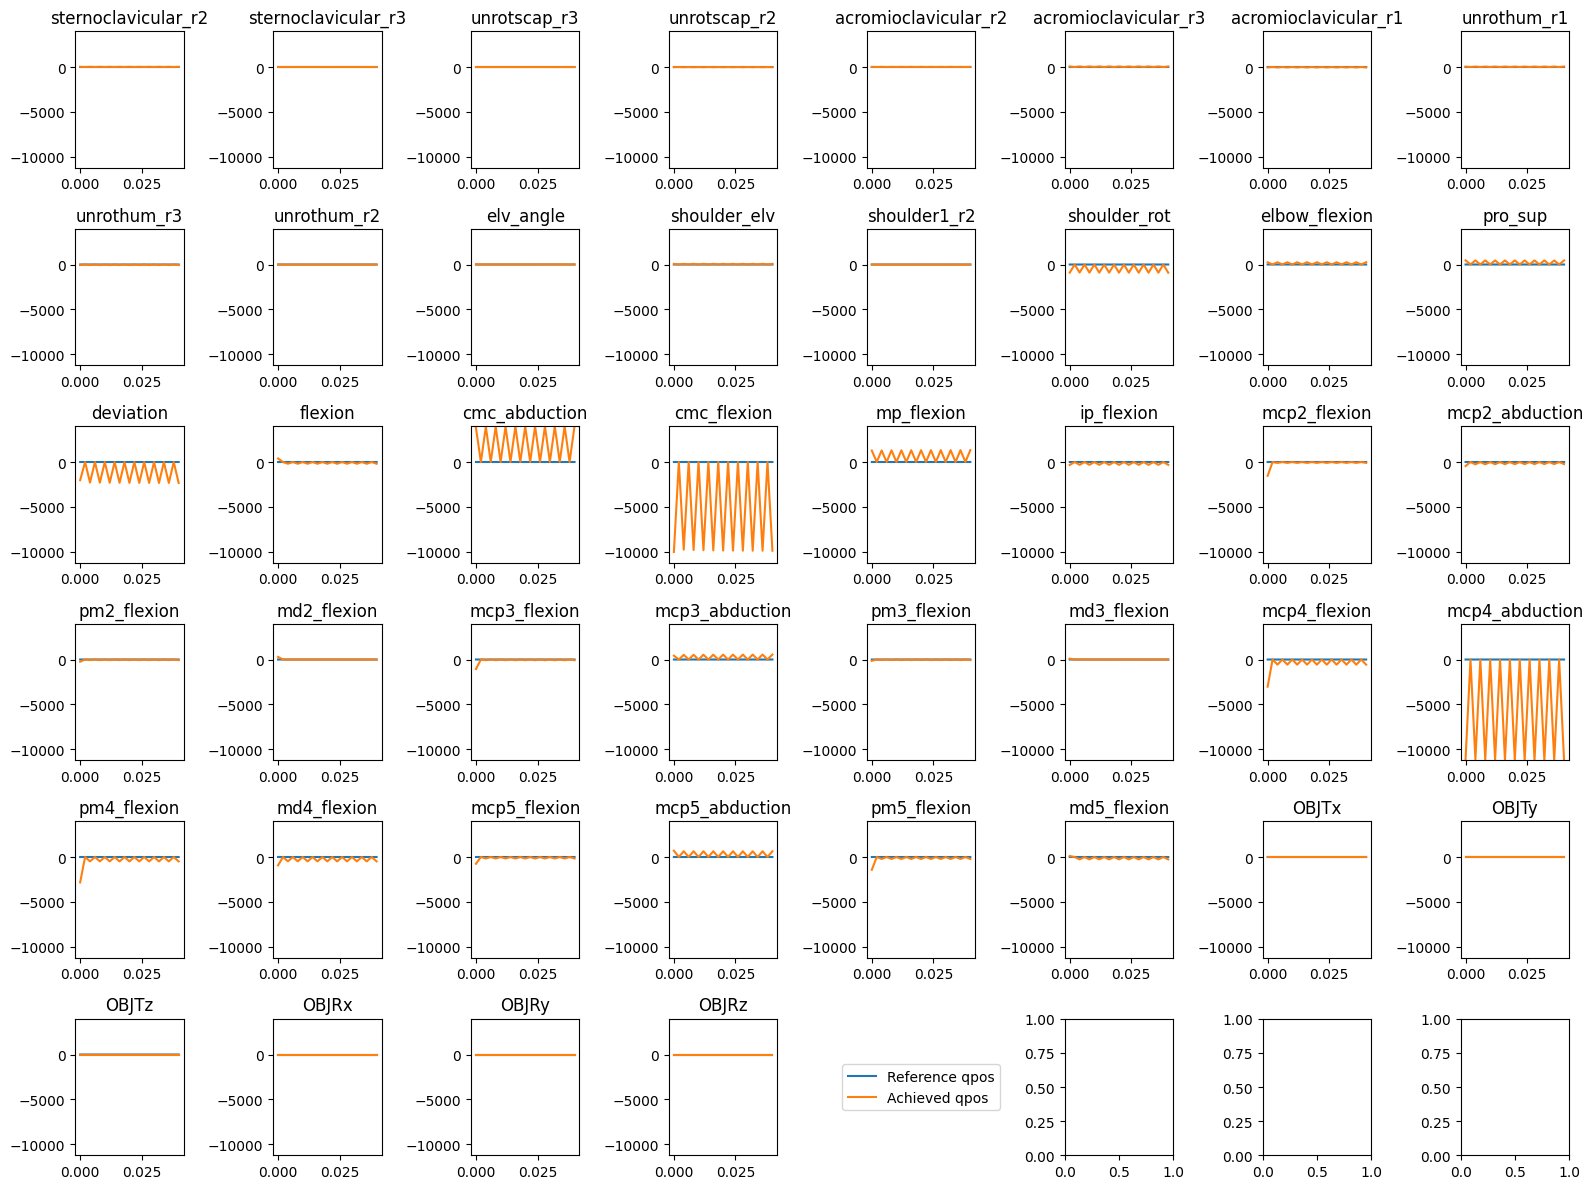

In [8]:
model0 = loader.get_sim(None, 'arm/myoarm_relocate.xml')
data0 = mujoco.MjData(model0)
all_qpos = np.zeros_like(traj)
for idx in (pbar := tqdm(range(traj.shape[0]))):
    data0.qfrc_applied = filt_qfrc[idx, 1:]
    mujoco.mj_step(model0, data0)
    all_qpos[idx,:] = np.hstack((data0.time, data0.qpos))
qpos_eval[:,:,1] = all_qpos
error = ((qpos_eval[:,1:,1] - qpos_eval[:,1:,0])**2).mean(axis=0)
print(f'Error max (rad): {error.max()}')
plot_qxxx(qpos_eval, joint_names, 'Reference qpos', 'Achieved qpos')

In [9]:
def get_ctrl(model, data, target_qpos, qfrc):
    """
    Compute the control needed to reach the target position in the next mujoco step.
    qfrc: generalized force resulting from inverse dynamics.
    """
    act = data.act
    ctrl0 = data.ctrl
    ts = model.opt.timestep
    tA = model.actuator_dynprm[:,0] * (0.5 + 1.5 * act)
    tD = model.actuator_dynprm[:,1] / (0.5 + 1.5 * act)
    tausmooth = model.actuator_dynprm[:,2]
    # ---- gain, bias, and moment computation
    data_copy = deepcopy(data)
    data_copy.qpos = target_qpos
    data_copy.qvel = (target_qpos - data.qpos) / model.opt.timestep
    mujoco.mj_step1(model, data_copy) # gain, bias, and moment depend on qpos and qvel
    gain = np.array([])
    bias = np.array([])
    for idx_actuator in range(model.nu):
        length = data_copy.actuator_length[idx_actuator]
        lengthrange = model.actuator_lengthrange[idx_actuator]
        velocity = data_copy.actuator_velocity[idx_actuator]
        acc0 = model.actuator_acc0[idx_actuator]
        prmb = model.actuator_biasprm[idx_actuator,:9]
        prmg = model.actuator_gainprm[idx_actuator,:9]
        bias = np.append(bias, mujoco.mju_muscleBias(length, lengthrange, acc0, prmb))
        gain = np.append(gain, min(-1, mujoco.mju_muscleGain(length, velocity, lengthrange, acc0, prmg)))
    AM = data_copy.actuator_moment.T
    # ---- ctrl computation
    t1 = (tA - tD) * 1.875 / tausmooth
    t2 = (tA + tD) * 0.5
    P = 2 * AM.T @ AM
    k = AM @ (gain * act) + AM @ bias - qfrc
    q = 2 * k @ AM
    lb = gain * (1 - act) * ts / (t2 + t1 * (1 - act))
    ub = - gain * act * ts / (t2 - t1 * act)
    x0 = (gain * (ctrl0 - act) * ts) / ((ctrl0 - act) * t1 + t2)
    x = solve_qp(P, q, lb, ub, x0)
    ctrl = act + x * t2 / (gain * ts - x * t1)
    return np.clip(ctrl,0,1)


In [10]:
model1 = loader.get_sim(None, 'arm/myoarm_relocate.xml')
tausmooth = 5
model1.actuator_dynprm[:,2] = tausmooth
data1 = mujoco.MjData(model1)
all_ctrl = np.zeros((traj.shape[0], 1+model1.nu))
for idx in (pbar := tqdm(range(traj.shape[0]))):
    target_qpos = traj[idx, 1:]
    qfrc = filt_qfrc[idx, 1:]
    ctrl = get_ctrl(model1, data1, target_qpos, qfrc)
    data1.ctrl = ctrl
    mujoco.mj_step(model1, data1)
    all_ctrl[idx,:] = np.hstack((data1.time, ctrl))

100%|██████████| 21/21 [00:00<00:00, 248.31it/s]


In [11]:
# ---- initializations
model_ref = loader.get_sim(None, 'arm/myoarm_relocate.xml')
model_ref.actuator_dynprm[:,2] = tausmooth
data_ref = mujoco.MjData(model_ref) # data for reference trajectory
model_test = loader.get_sim(None, 'arm/myoarm_relocate.xml')
model_test.actuator_dynprm[:,2] = tausmooth
data_test = mujoco.MjData(model_test) # test data for achieved trajectory
# ---- camera settings
camera = mujoco.MjvCamera()
camera.azimuth = 166.553
camera.distance = 2
camera.elevation = -36.793
camera.lookat = np.array([-0.93762553, -0.34088276, 0.85067529])
options_ref = mujoco.MjvOption()
options_ref.flags[:] = 0
options_ref.geomgroup[1:] = 0
options_test = mujoco.MjvOption()
options_test.flags[:] = 0
options_test.flags[4] = 1 # actuator ON
options_test.geomgroup[1:] = 0
renderer_ref = mujoco.Renderer(model_ref)
renderer_ref.scene.flags[:] = 0
renderer_test = mujoco.Renderer(model_test)
renderer_test.scene.flags[:] = 0
# ---- generation loop
frames = []
all_qpos = np.zeros_like(traj)
for idx in (pbar := tqdm(range(traj.shape[0]))):
    # -- reference trajectory
    data_ref.qpos = traj[idx, 1:]
    mujoco.mj_step(model_ref, data_ref)
    renderer_ref.update_scene(data_ref, camera=camera, scene_option=options_ref)
    frame_ref = renderer_ref.render()
    # -- achieved trajectory
    data_test.ctrl = all_ctrl[idx, 1:]
    mujoco.mj_step(model_test, data_test)
    all_qpos[idx,:] = np.hstack((data_test.time, data_test.qpos))
    renderer_test.update_scene(data_test, camera=camera, scene_option=options_test)
    frame_test = renderer_test.render()
    # -- frames merging 
    frame_merged = np.append(frame_ref, frame_test, axis=1)
    frames.append(frame_merged)
# -- frames writing
print(frames)
os.makedirs('videos', exist_ok = True)
output_name = 'videos/freemovement.mp4'
imageio.mimsave(output_name, frames, fps=30)



100%|██████████| 21/21 [00:00<00:00, 46.63it/s]


[array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,

In [12]:
show_video(output_name)